In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dữ liệu từ các file csv
AAPL = pd.read_csv("/content/drive/MyDrive/AAPL.csv")
ABB = pd.read_csv("/content/drive/MyDrive/ABB.csv")
ABBV = pd.read_csv("/content/drive/MyDrive/ABBV.csv")
AMGN = pd.read_csv("/content/drive/MyDrive/AMGN.csv")
AEP = pd.read_csv("/content/drive/MyDrive/AEP.csv")


# Kiểm tra cấu trúc dataframe
print(AAPL.info())
print(ABB.info())
print(ABBV.info())
print(AMGN.info())
print(AEP.info())

# In dataframe để kiểm tra
print(AAPL.head())
print(ABB.head())
print(ABBV.head())
print(AMGN.head())
print(AEP.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  


In [ ]:
def find_and_replace_null_with_mean(df, name):
    # Tìm các dòng chứa giá trị null
    null_rows = df[df.isnull().any(axis=1)]
    if not null_rows.empty:
        print(f"Các dòng chứa giá trị null trong {name}:")
        print(null_rows)

        # Thay thế các giá trị null bằng giá trị mean của từng cột
        for column in df.columns:
            if df[column].isnull().any():
                column_mean = df[column].mean()
                df[column].fillna(column_mean, inplace=True)
                print(f"Đã thay thế giá trị null trong cột {column} bằng giá trị mean của cột ({column_mean})")

    else:
        print(f"Không có giá trị null trong {name}.")

    return df

AAPL = find_and_replace_null_with_mean(AAPL, "AAPL")
ABB = find_and_replace_null_with_mean(ABB, "ABB")
ABBV = find_and_replace_null_with_mean(ABBV, "ABBV")
AMGN = find_and_replace_null_with_mean(AMGN, "AMGN")
AEP = find_and_replace_null_with_mean(AEP, "AEP")

Không có giá trị null trong AAPL.
Không có giá trị null trong ABB.
Không có giá trị null trong ABBV.
Không có giá trị null trong AMGN.
Không có giá trị null trong AEP.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def find_best_arima_parameters(company_data):
    # Extract 'Close' column from company_data DataFrame
    data = company_data['Close'].values

    # Define training and testing data lengths
    training_data_len = int(np.ceil(len(data) * 0.95))
    train_data = data[:training_data_len]
    test_data = data[training_data_len:]

    # Initialize variables to store best parameters and minimum AIC
    best_aic = np.inf
    best_order = None

    # Search through possible combinations of p, d, q
    p_values = range(0, 6)
    d_values = range(0, 2)
    q_values = range(0, 6)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()

                    # Calculate AIC (Akaike Information Criterion)
                    current_aic = model_fit.aic

                    # Update best parameters if current AIC is lower
                    if current_aic < best_aic:
                        best_aic = current_aic
                        best_order = (p, d, q)

                except:
                    continue

    print(f"Best ARIMA order: {best_order}")
    print(f"Best AIC value: {best_aic}")

    return best_order, best_aic

def train_and_evaluate_arima(company_data):
    # Extract 'Close' column from company_data DataFrame
    data = company_data['Close'].values

    # Define training and testing data lengths
    training_data_len = int(np.ceil(len(data) * 0.95))
    train_data = data[:training_data_len]
    test_data = data[training_data_len:]

    # Find the best ARIMA parameters
    best_order, best_aic = find_best_arima_parameters(company_data)

    # Initialize lists to store predictions and actual values
    predictions = []
    actuals = []

    # Fit ARIMA model with best parameters and make predictions
    history = list(train_data)
    for t in range(len(test_data)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        actuals.append(test_data[t])
        history.append(test_data[t])

    # Calculate error metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    error = np.mean((np.abs(predictions - actuals) * 200 / (np.abs(predictions) + np.abs(actuals))))

    return model_fit, predictions, rmse, error, training_data_len, data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions(data, training_data_len, predictions, company_name):
    # Convert numpy array to DataFrame
    data = pd.DataFrame(data, columns=['Close'])  # Assuming 'Close' is the column name

    # Create the training and validation data
    train = data[:training_data_len]
    valid = data[training_data_len:]  # Make a copy to avoid modifying original data

    # Convert predictions to a pandas Series with proper index
    predictions_series = pd.Series(predictions, index=valid.index)

    # Add predictions to the valid DataFrame
    valid['Predictions'] = predictions_series

    # Visualize the training and validation data along with predictions
    plt.figure(figsize=(16, 6))
    plt.title(f'Model Predictions for {company_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], label='Train Data')
    plt.plot(valid['Close'], label='Validation Data')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.axvline(x=valid.index[0], color='k', linestyle='--', linewidth=0.5)  # Separate train and valid data
    plt.legend(loc='lower right')
    plt.show()

    # Plot only validation data and predictions
    plt.figure(figsize=(16, 6))
    plt.title(f'Model Predictions vs Validation Data for {company_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(valid['Close'], label='Validation Data')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
model_AAPL, predictions_AAPL, rmse_AAPL, error_AAPL,training_data_len_AAPL,data_AAPL = train_and_evaluate_arima(AAPL)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Best ARIMA order: (0, 1, 0)
Best AIC value: 4385.899418968813


In [ ]:
rmse_AAPL

2.015135651732025

In [ ]:
predictions_AAPL

array([154.449997, 155.369995, 154.990005, 148.979996, 145.419998,
       146.589996, 145.160004, 144.289993, 142.270004, 146.339996,
       145.009995, 145.869995, 145.630005, 146.279999, 145.820007,
       143.729996, 145.830002, 143.679993, 144.020004, 143.5     ,
       144.089996, 142.729996, 144.179993, 145.059998, 145.529999,
       145.740005, 147.770004, 149.039993, 149.559998, 150.080002,
       151.020004, 150.339996, 150.270004, 152.089996, 152.740005,
       153.460007, 150.559998, 149.5     , 148.729996, 150.050003,
       157.139999, 155.570007, 156.389999, 158.809998, 160.080002,
       161.059998, 155.320007, 157.479996, 159.850006, 161.600006,
       160.949997, 157.860001, 157.5     , 157.210007, 159.779999,
       159.979996, 159.270004, 159.860001, 161.470001, 162.910004,
       163.350006, 164.      ])

<ipython-input-7-b626c716bf6b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_series


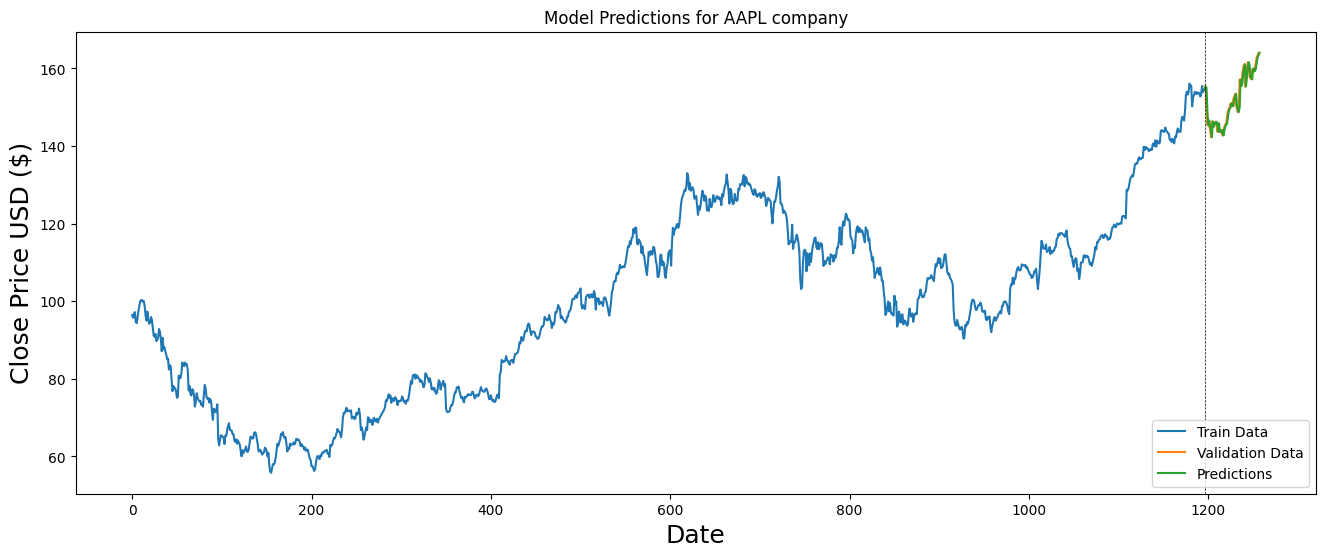

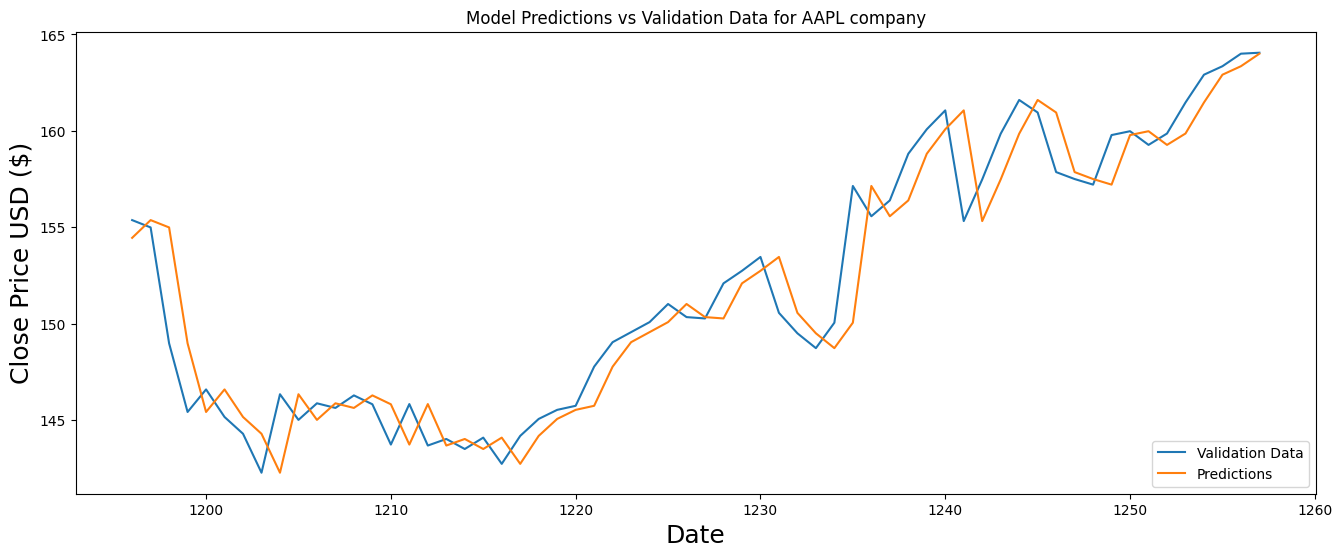

In [ ]:
plot_predictions(data_AAPL, training_data_len_AAPL, predictions_AAPL, "AAPL company")

In [ ]:
model_ABB, predictions_ABB, rmse_ABB, error_ABB, training_data_len_ABB, data_ABB = train_and_evaluate_arima(ABB)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Best ARIMA order: (1, 1, 4)
Best AIC value: 261.26788834676813


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-7-b626c716bf6b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_series


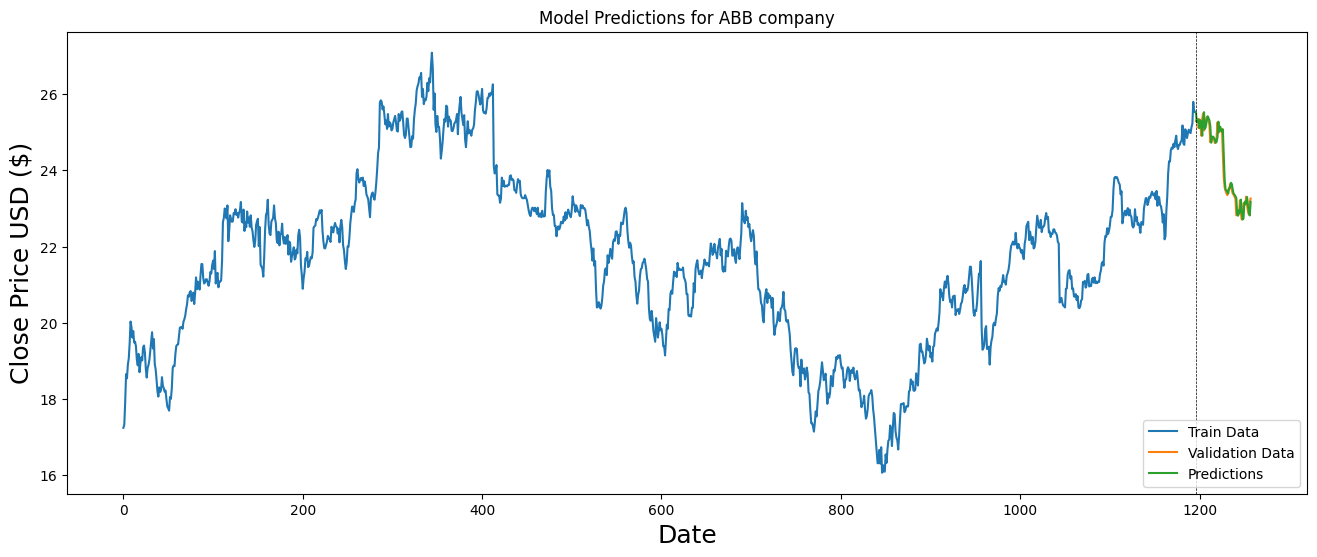

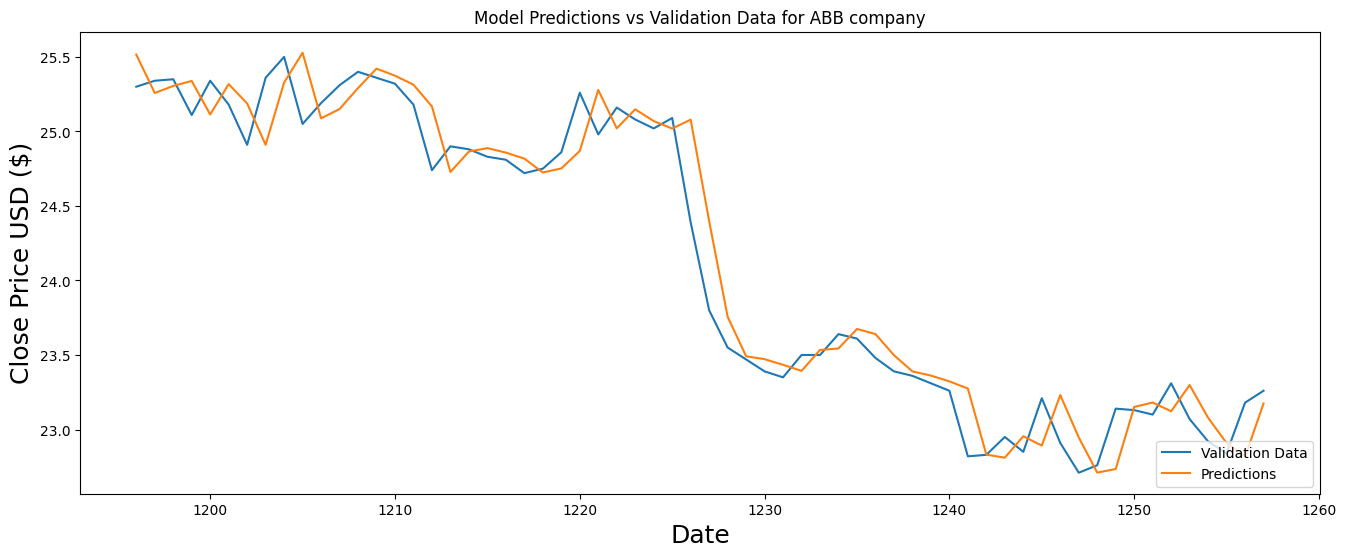

In [ ]:
plot_predictions(data_ABB, training_data_len_ABB, predictions_ABB, "ABB company")

In [ ]:
model_ABBV, predictions_ABBV, rmse_ABBV, error_ABBV, training_data_len_ABBV, data_ABBV = train_and_evaluate_arima(ABBV)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Best ARIMA order: (4, 1, 4)
Best AIC value: 2995.3894493584125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

<ipython-input-7-b626c716bf6b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_series


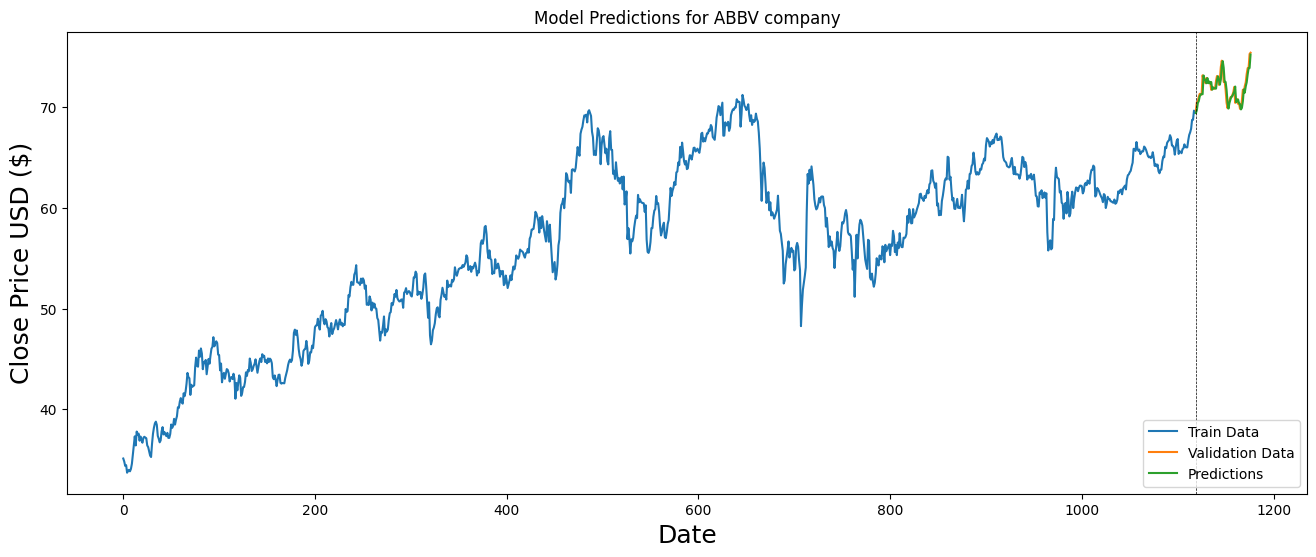

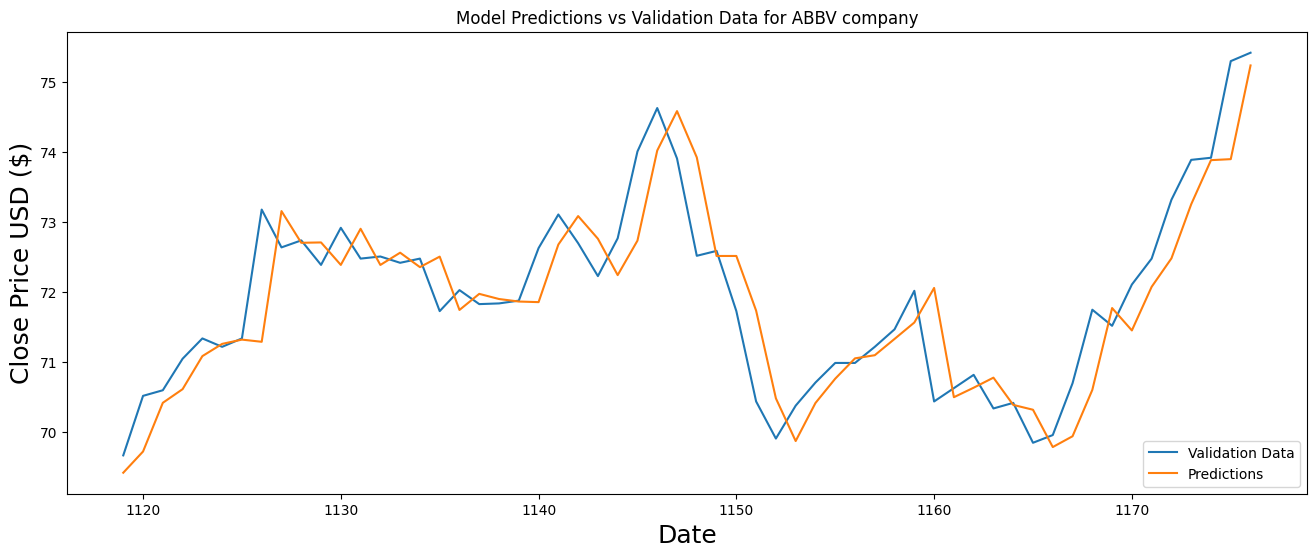

In [ ]:
plot_predictions(data_ABBV, training_data_len_ABBV, predictions_ABBV, "ABBV company")

In [ ]:
model_AMGN, predictions_AMGN, rmse_AMGN, error_AMGN, training_data_len_AMGN, data_AMGN = train_and_evaluate_arima(AMGN)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Best ARIMA order: (2, 1, 5)
Best AIC value: 5270.113142365686


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

<ipython-input-7-b626c716bf6b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_series


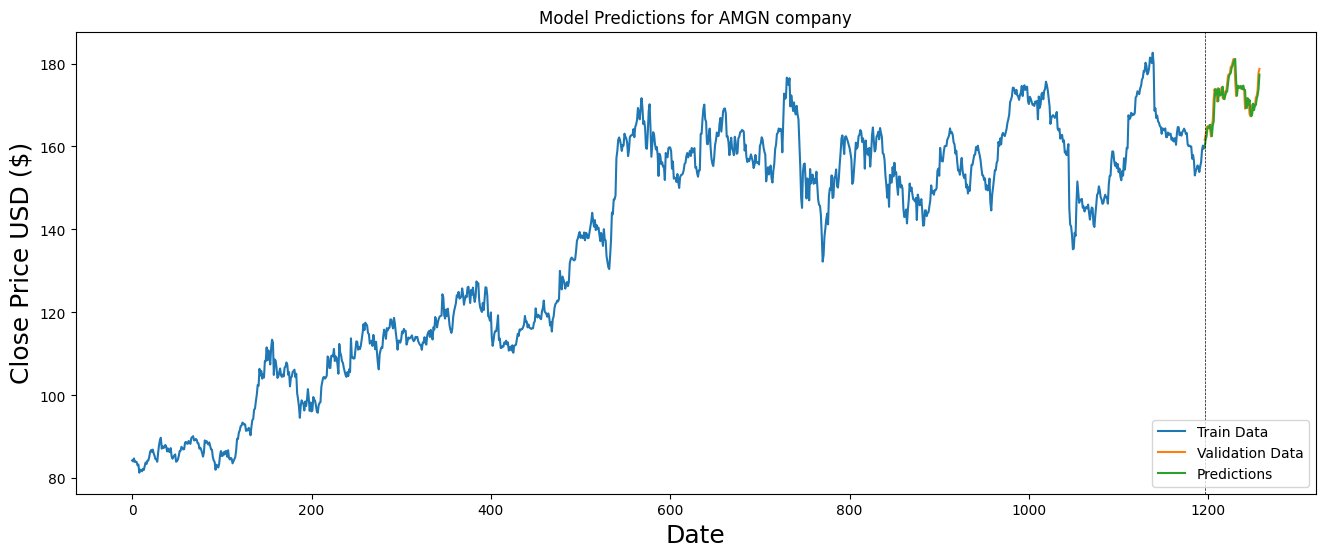

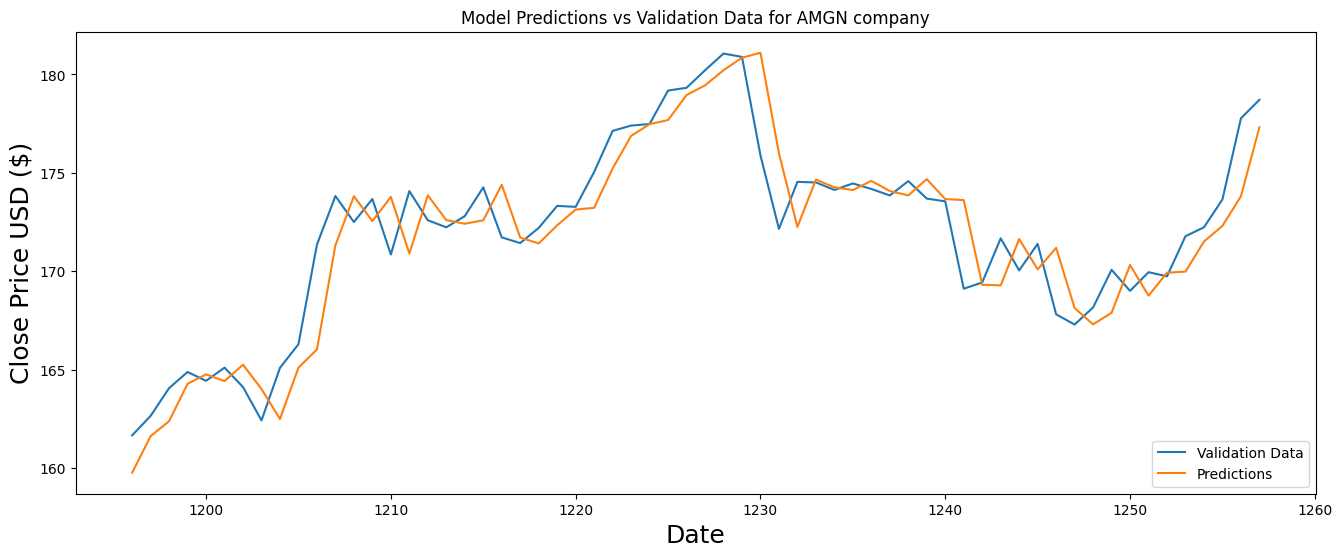

In [ ]:
plot_predictions(data_AMGN, training_data_len_AMGN, predictions_AMGN, "AMGN company")

In [ ]:
model_AEP, predictions_AEP, rmse_AEP, error_AEP, training_data_len_AEP, data_AEP = train_and_evaluate_arima(AEP)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Best ARIMA order: (0, 1, 0)
Best AIC value: 2119.5395789501313


<ipython-input-7-b626c716bf6b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_series


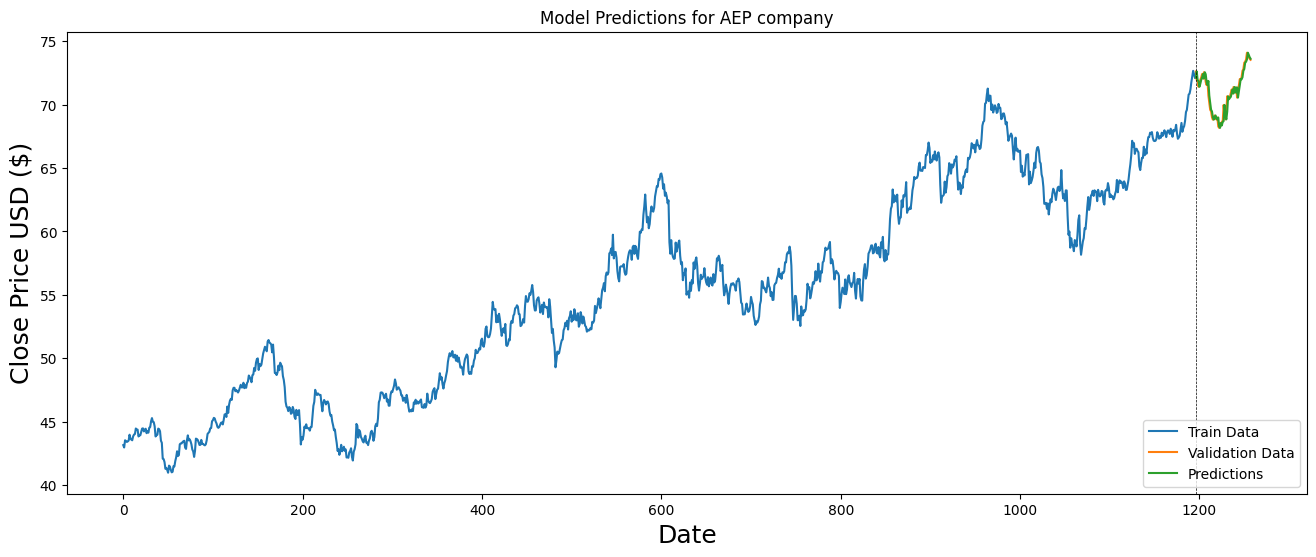

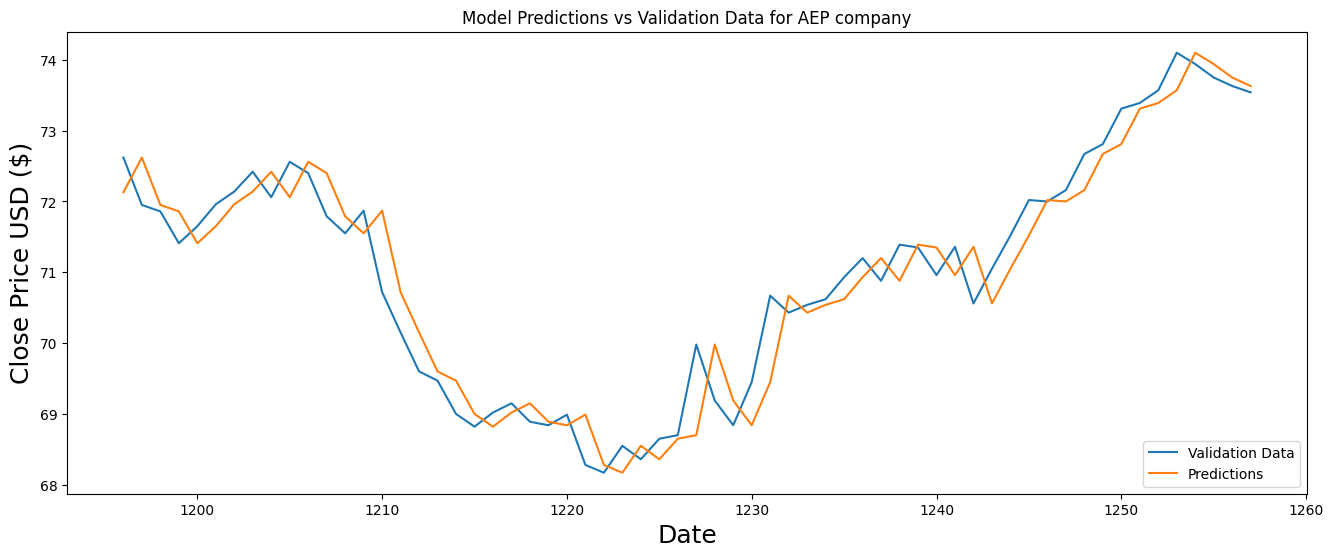

In [ ]:
plot_predictions(data_AEP, training_data_len_AEP, predictions_AEP, "AEP company")

In [ ]:
print(f"RMSE for AAPL: {rmse_AAPL}")
print(f"RMSE for ABB: {rmse_ABB}")
print(f"RMSE for ABBV: {rmse_ABBV}")
print(f"RMSE for AMGN: {rmse_AMGN}")
print(f"RMSE for AEP: {rmse_AEP}")

RMSE for AAPL: 2.015135651732025
RMSE for ABB: 0.22684942738829894
RMSE for ABBV: 0.6443949802830786
RMSE for AMGN: 1.9025113269421619
RMSE for AEP: 0.45315633100705377
